Demonstration of usage for the Langevin diffuser

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
from jax.scipy.stats import norm

from datasets import GMM
from schedulers import linear_schedule
from langevin import LangevinConfig, LangevinDiffusion

ULA for sampling from GMM

In [3]:
# Parameters for the Gaussian Mixture Model (GMM)
prior = [0.5, 0.5]  # Priors for the two components
means = [-1, 1] # Means for each component
stds = [0.5, 0.5] # Standard deviations for each component
num_samples = 10_000 # Number of samples to generate

# Generate RandomKey
key = jax.random.PRNGKey(0)

# Configuration for the Langevin Diffuser
T = 1000
langevin_config = LangevinConfig(
    T=T, step_size=0.01
)
# Instantiate Langevin Diffuser
langevin_difusser = LangevinDiffusion(langevin_config)

# Score function for GMM
score_fn = lambda x : score_gmm(x, prior, means, stds)
# Initialisation from standard normal
x_0 = jax.random.normal(key, shape=(num_samples, 1))
# Split the random key
key, _ = jax.random.split(key)
# Run ULA algorithm
x_T = langevin_difusser.ula_diffusion(x_0, score_fn, key)

100%|██████████| 1000/1000 [00:00<00:00, 1067.21it/s]


Visualisation of samples along with ground-truth density

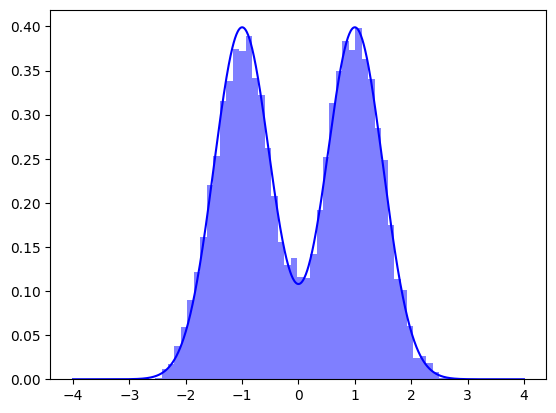

In [8]:
x_values = jnp.linspace(-4, 4, 1000)
gmm_density_values = gmm_density(x_values, prior, means, stds)

plt.hist(np.array(x_T), density=True, bins=50, color='blue', alpha=0.5)
plt.plot(x_values, np.array(gmm_density_values), label='GMM Density', color='blue')
plt.show()

Example of MALA diffusion

In [17]:
# Parameters for the Gaussian Mixture Model (GMM)
prior = [0.5, 0.5]  # Priors for the two components
means = [-1, 1] # Means for each component
stds = [0.5, 0.5] # Standard deviations for each component
num_samples = 10_000 # Number of samples to generate

# Generate RandomKey
key = jax.random.PRNGKey(0)

# Configuration for the Langevin Diffuser
T = 1000
langevin_config = LangevinConfig(
    T=T, step_size=0.5
)
# Instantiate Langevin Diffuser
langevin_difusser = LangevinDiffusion(langevin_config)

# Score function for GMM
score_fn = lambda x : score_gmm(x, prior, means, stds)
log_gmm_density_fn = lambda x : log_gmm_density(x, prior, means, stds)
# Initialisation from standard normal
x_0 = jax.random.normal(key, shape=(num_samples, 1))
# Split the random key
key, _ = jax.random.split(key)
# Run ULA algorithm
x_T = langevin_difusser.mala_diffusion(x_0, log_gmm_density_fn, score_fn, key)

100%|██████████| 1000/1000 [00:03<00:00, 317.73it/s, acc=0.486]


Visualisation of samples along with ground-truth density

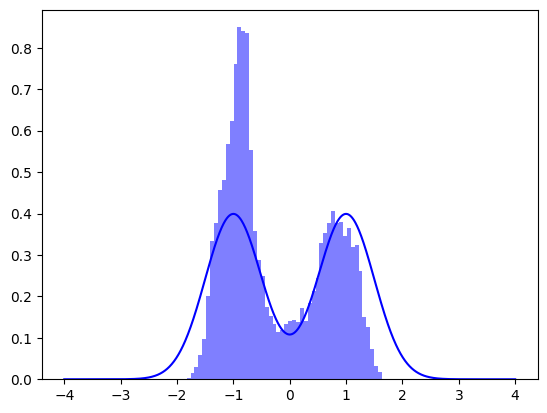

In [18]:
x_values = jnp.linspace(-4, 4, 1000)
gmm_density_values = gmm_density(x_values, prior, means, stds)

plt.hist(np.array(x_T), density=True, bins=50, color='blue', alpha=0.5)
plt.plot(x_values, np.array(gmm_density_values), label='GMM Density', color='blue')
plt.show()

Annealed langevin to sample from normal (scores can be computed by hand)

In [21]:
# Generate RandomKey
key = jax.random.PRNGKey(0)
# x_0 is N(2, 0.01)
# Start the diffusion sampling from a standard normal
_mean_x_0 = 2.
_std_x_0 = 0.1
x_0 = _mean_x_0 + _std_x_0*jax.random.normal(key, shape=(num_samples, 1))

In [5]:
# Definition of the score functions for forward and backward diffusions
# Score function based on noise
_sigma_squared = linear_schedule(T)
_gamma_squared = 1. - _sigma_squared
_gamma = jnp.sqrt(_gamma_squared)
_prod_gamma = jnp.cumprod(_gamma)
_prod_gamma_squared = jnp.cumprod(_gamma_squared)

# Score function for initial normal distribution
def score_fn(x_t: jnp.array, t: int):
    return -(x_t - _prod_gamma[t]*_mean_x_0)/((_prod_gamma[t]*_std_x_0)**2 + (1. - _prod_gamma_squared[t]))

# Score function for initial normal distribution
def score_fn_reversed(x_t: jnp.array, t: int):
    return -(x_t - _prod_gamma[T-t-1]*_mean_x_0)/((_prod_gamma[T-t-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-t-1]))

In [13]:
# Instantiation of LangevinDiffuser
# Configuration for the Langevin Diffuser
T = 50
steps_per_level = 1
langevin_config = LangevinConfig(
    T=T, step_size=0.01
)
langevin_diffuser = LangevinDiffusion(langevin_config)

# Run backward diffusion
# x_T is N(0, 1)
key, _ = jax.random.split(key)
x_T = jax.random.normal(key, shape=(num_samples, 1))
# Split the random key
key, _ = jax.random.split(key)
x_1 = langevin_diffuser.annealed_langevin(x_T, score_fn_reversed, steps_per_level, key, (1. - _prod_gamma_squared))
# Last sample has noise, that needs to be removed
x_0 = (x_1 + (1. - _prod_gamma_squared[0])*score_fn(x_1, 0))/_gamma[0]

100%|██████████| 50/50 [00:00<00:00, 1318.12it/s]


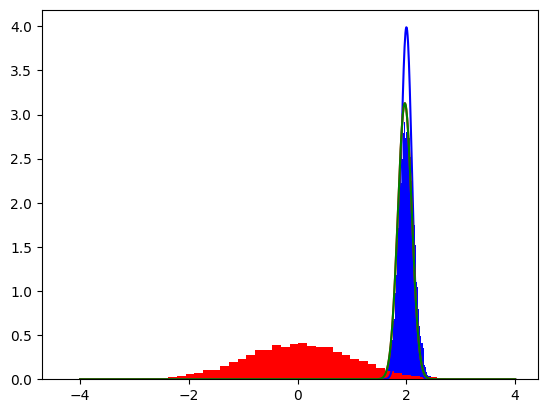

In [14]:
# Visualisation code
x_values = jnp.linspace(-4, 4, 1000)
density_x_0 = norm.pdf(x_values, loc=_mean_x_0, scale=_std_x_0)
density_x_T = norm.pdf(x_values, loc=_mean_x_0*_prod_gamma[T-1], scale=jnp.sqrt(_prod_gamma[T-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-1]))
density_standard = norm.pdf(x_values, loc=_mean_x_0*_prod_gamma[T-1], scale=jnp.sqrt(_prod_gamma[T-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-1]))
plt.hist(np.array(x_0), density=True, bins=50, color='blue')
plt.hist(np.array(x_T), density=True, bins=50, color='red')
plt.plot(x_values, np.array(density_x_0), label='Density x_0', color='blue')
plt.plot(x_values, np.array(density_x_T), label='Density x_T', color='red')
plt.plot(x_values, np.array(density_standard), label='Density Standard', color='green')
plt.show()

In [12]:
# Compute samples log-likelihood
log_likelihood = np.mean(norm.logpdf(x_1, loc=_mean_x_0, scale=_std_x_0))
print(log_likelihood)

0.40697098


Annealed Langevin in GMM

In [18]:
# Generate RandomKey
key = jax.random.PRNGKey(0)
# Configuration
T = 50
# Parameters for the Gaussian Mixture Model (GMM)
prior = jnp.array([[0.5], [0.5]])  # Priors for the two components
means = jnp.array([[-1], [1]]) # Means for each component
stds = jnp.array([[0.5], [0.5]]) # Standard deviations for each component
num_samples = 10_000 # Number of samples to generate
# Definition of the score functions for forward and backward diffusions
# Score function based on noise
_sigma_squared = linear_schedule(T)
_gamma_squared = 1. - _sigma_squared
_gamma = jnp.sqrt(_gamma_squared)
_prod_gamma = jnp.cumprod(_gamma)
_prod_gamma_squared = jnp.cumprod(_gamma_squared)
# Initialise GMM

gmm = GMM(prior, means, stds, linear_schedule(T))

langevin_config = LangevinConfig(
    T=T, step_size=0.01
)
langevin_diffuser = LangevinDiffusion(langevin_config)

# Run backward diffusion
# x_T is N(0, 1)
key, _ = jax.random.split(key)
x_T = jax.random.normal(key, shape=(num_samples, 1))
# Split the random key
key, _ = jax.random.split(key)
x_1 = langevin_diffuser.annealed_langevin(x_T, gmm.noisy_score_reversed, 10, key, (1. - _prod_gamma_squared))
# Last sample has noise, that needs to be removed
x_0 = (x_1 + (1. - _prod_gamma_squared[0])*gmm.noisy_score(x_1, 0))/_gamma[0]


100%|██████████| 50/50 [00:01<00:00, 48.76it/s]


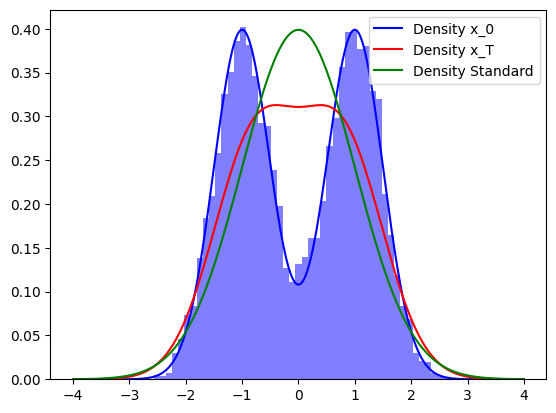

In [19]:
# Visualisation code
x_values = jnp.linspace(-4, 4, 1000)
density_x_0 = jnp.squeeze(gmm.noisy_density(jnp.expand_dims(x_values, axis=-1), 0))
density_x_T = jnp.squeeze(gmm.noisy_density(jnp.expand_dims(x_values, axis=-1), T-1))
density_standard = norm.pdf(x_values)
plt.hist(np.array(x_0), density=True, bins=50, color='blue', alpha=0.5)
#plt.hist(np.array(x_T), density=True, bins=50, color='red', alpha=0.5)
plt.plot(x_values, np.array(density_x_0), label='Density x_0', color='blue')
plt.plot(x_values, np.array(density_x_T), label='Density x_T', color='red')
plt.plot(x_values, np.array(density_standard), label='Density Standard', color='green')
plt.legend()
plt.show()

Annealed Langevin in hard GMM

In [4]:
from schedulers import NoiseScheduler, cosine_schedule
from datasets import load_hard_gmm
from visualisation_utils import plot_gmm
# Generate RandomKey
key = jax.random.PRNGKey(0)
# Configuration
T = 100
num_samples = 1000
noise_scheduler = NoiseScheduler(cosine_schedule)
gmm = load_hard_gmm(noise_scheduler)

langevin_config = LangevinConfig(
    T=T, step_size=0.001
)
langevin_diffuser = LangevinDiffusion(langevin_config)

# Run backward diffusion
# x_T is N(0, 1)
key, subkey = jax.random.split(key)
x_T = jax.random.normal(key, shape=(num_samples, gmm.dim))
# Split the random key
key, _ = jax.random.split(key)
x_1 = langevin_diffuser.annealed_langevin_continuous(x_T, gmm.noisy_score_reversed, 1, key)

print(x_1.shape)


  9%|▉         | 9/100 [00:02<00:25,  3.57it/s]


KeyboardInterrupt: 

[[-1.3586866  -0.8124489 ]
 [-0.22296733 -0.05703836]
 [ 0.7090428  -1.329161  ]
 ...
 [-1.1244745   1.047342  ]
 [ 0.26680824  1.0997652 ]
 [-0.5990002   0.95943725]]


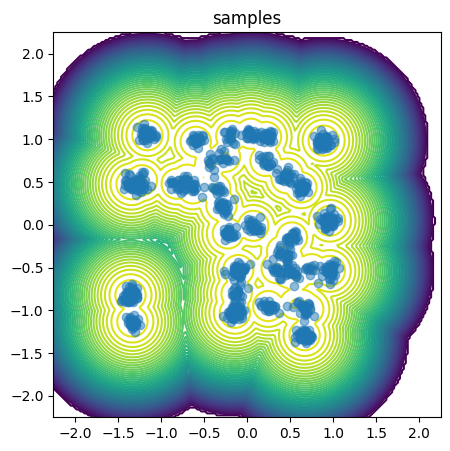

In [15]:
from visualisation_utils import plot_gmm

plot_gmm(
    x_1,
    lambda x : jnp.squeeze(gmm.log_density(x)),
    1.5,
)
print(x_1)

(<Figure size 500x500 with 1 Axes>, <Axes: title={'center': 'samples'}>)

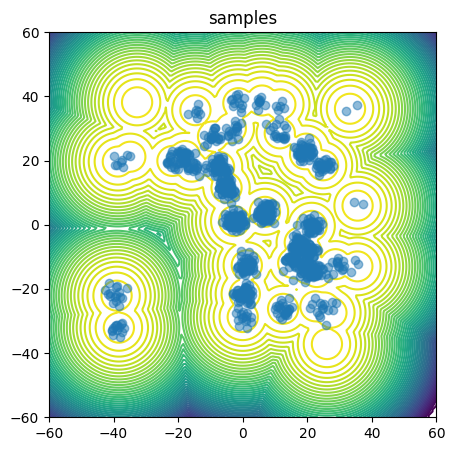

In [10]:
from schedulers import NoiseScheduler, cosine_schedule
from datasets import load_hard_gmm
# Generate RandomKey
key = jax.random.PRNGKey(0)
# Configuration
T = 100
num_samples = 1000
noise_scheduler = NoiseScheduler(cosine_schedule)
gmm = load_hard_gmm(noise_scheduler, standarised=False)

langevin_config = LangevinConfig(
    T=T, step_size=1.0
)
langevin_diffuser = LangevinDiffusion(langevin_config)

# Run backward diffusion
# x_T is N(0, 1)
key, subkey = jax.random.split(key)
x_T = jax.random.normal(key, shape=(num_samples, gmm.dim))
# Split the random key
key, subkey = jax.random.split(key)

class DummyDriftCorrection:
    def apply(self, params, x):
        return jnp.zeros(shape=(num_samples,x.shape[1]-1), dtype=np.float32)

dummy_drift_correction = DummyDriftCorrection()

 # Use validation data
x_0, log_w = langevin_diffuser.cmcd_diffusion(
    None,
    x_T,
    dummy_drift_correction,
    gmm.noisy_score_reversed,
    gmm.log_density,
    lambda x : norm.logpdf(x),
    subkey,
)

plot_gmm(
    x_0,
    lambda x : jnp.squeeze(gmm.log_density(x)),
    40.,
)


CMCD Diffusion

In [20]:
# Instantiation of LangevinDiffuser
# Configuration for the Langevin Diffuser
T = 50
steps_per_level = 1
num_samples = 10_000 # Number of samples to generate

langevin_config = LangevinConfig(
    T=T, step_size=0.01
)
langevin_diffuser = LangevinDiffusion(langevin_config)

# Score function for initial normal distribution
def score_fn_reversed(x_t: jnp.array, t: int):
    return -(x_t - _prod_gamma[T-t-1]*_mean_x_0)/((_prod_gamma[T-t-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-t-1]))

_sigma_squared = linear_schedule(T)
_gamma_squared = 1. - _sigma_squared
_gamma = jnp.sqrt(_gamma_squared)
_prod_gamma = jnp.cumprod(_gamma)
_prod_gamma_squared = jnp.cumprod(_gamma_squared)

class DummyDriftCorrection:
    def apply(self, params, x):
        return jnp.zeros(shape=(num_samples,1), dtype=np.float32)

dummy_drift_correction = DummyDriftCorrection()

# Run backward diffusion
# x_T is N(0, 1)
key, _ = jax.random.split(key)
x_T = jax.random.normal(key, shape=(num_samples, 1))
# Split the random key
key, _ = jax.random.split(key)

# Do not include drift correction
x_1, log_w = langevin_diffuser.cmcd_train(
    None, 
    x_T, 
    dummy_drift_correction, 
    score_fn_reversed,
    lambda x : norm.logpdf(x, loc=_mean_x_0, scale=_std_x_0),
    lambda x : norm.logpdf(x),
    (1. - _prod_gamma_squared),
    key,
)
# Last sample has noise, that needs to be removed
x_0 = (x_1 + (1. - _prod_gamma_squared[0])*score_fn(x_1, 0))/_gamma[0]


NameError: name '_mean_x_0' is not defined

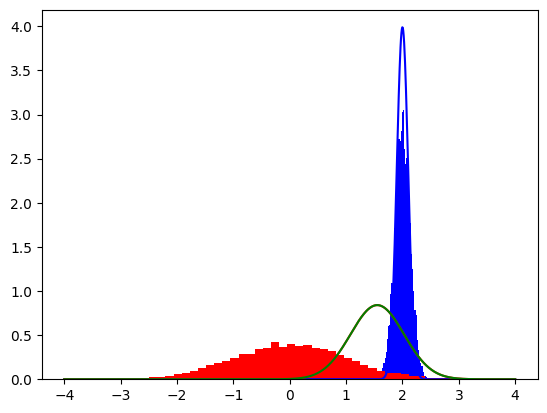

In [22]:
# Visualisation code
x_values = jnp.linspace(-4, 4, 1000)
density_x_0 = norm.pdf(x_values, loc=_mean_x_0, scale=_std_x_0)
density_x_T = norm.pdf(x_values, loc=_mean_x_0*_prod_gamma[T-1], scale=jnp.sqrt(_prod_gamma[T-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-1]))
density_standard = norm.pdf(x_values, loc=_mean_x_0*_prod_gamma[T-1], scale=jnp.sqrt(_prod_gamma[T-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-1]))
plt.hist(np.array(x_0), density=True, bins=50, color='blue')
plt.hist(np.array(x_T), density=True, bins=50, color='red')
plt.plot(x_values, np.array(density_x_0), label='Density x_0', color='blue')
plt.plot(x_values, np.array(density_x_T), label='Density x_T', color='red')
plt.plot(x_values, np.array(density_standard), label='Density Standard', color='green')
plt.show()

In [25]:
from jax.scipy.special import logsumexp

# Compute samples log-likelihood
log_likelihood = np.mean(norm.logpdf(x_1, loc=_mean_x_0, scale=_std_x_0))
print(log_likelihood)
# Comptue efective sample size
adjusted_sample_size = num_samples/(1. + jnp.var(jnp.exp(log_w - logsumexp(log_w, axis=0, keepdims=True) + jnp.log(num_samples))))
print(adjusted_sample_size)


0.4156682
2.51707


In [22]:
from models import MLP

# Instantiation of LangevinDiffuser
# Configuration for the Langevin Diffuser
T = 50
steps_per_level = 1
num_samples = 10_000 # Number of samples to generate

langevin_config = LangevinConfig(
    T=T, step_size=0.01
)
langevin_diffuser = LangevinDiffusion(langevin_config)

# Score function for initial normal distribution
def score_fn_reversed(x_t: jnp.array, t: int):
    return -(x_t - _prod_gamma[T-t-1]*_mean_x_0)/((_prod_gamma[T-t-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-t-1]))

_sigma_squared = linear_schedule(T)
_gamma_squared = 1. - _sigma_squared
_gamma = jnp.sqrt(_gamma_squared)
_prod_gamma = jnp.cumprod(_gamma)
_prod_gamma_squared = jnp.cumprod(_gamma_squared)

# Initialise drift correction model
drift_correction = MLP(hidden_dim=128, out_dim=1, n_layers=3)
# Sample elements for initialisation
key, _ = jax.random.split(key)
x_T = jax.random.normal(key, shape=(T, 1))
t_T = jnp.expand_dims(jnp.linspace(start=0, stop=T, num=T)/T, axis=-1)
# Init with an element for all steps
params = drift_correction.init(key, jnp.concatenate([x_T, t_T], axis=-1))

dummy_drift_correction = DummyDriftCorrection()

# Run backward diffusion
# x_T is N(0, 1)
key, _ = jax.random.split(key)
x_T = jax.random.normal(key, shape=(num_samples, 1))
# Split the random key
key, _ = jax.random.split(key)

# Do not include drift correction
x_1, log_w = langevin_diffuser.cmcd_train(
    params, 
    x_T, 
    drift_correction, 
    score_fn_reversed,
    lambda x : norm.logpdf(x, loc=_mean_x_0, scale=_std_x_0),
    lambda x : norm.logpdf(x),
    (1. - _prod_gamma_squared),
    key,
)
# Last sample has noise, that needs to be removed
x_0 = (x_1 + (1. - _prod_gamma_squared[0])*score_fn(x_1, 0))/_gamma[0]


NameError: name 'score_fn' is not defined

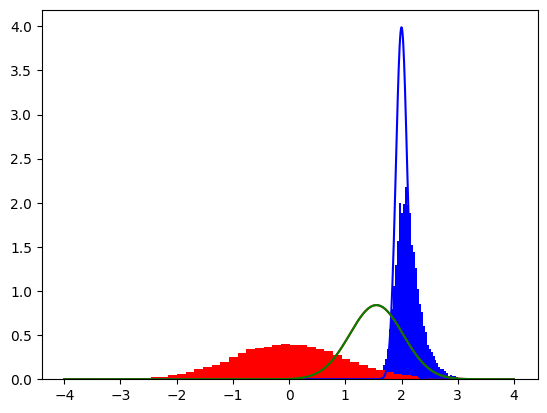

In [27]:
# Visualisation code
x_values = jnp.linspace(-4, 4, 1000)
density_x_0 = norm.pdf(x_values, loc=_mean_x_0, scale=_std_x_0)
density_x_T = norm.pdf(x_values, loc=_mean_x_0*_prod_gamma[T-1], scale=jnp.sqrt(_prod_gamma[T-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-1]))
density_standard = norm.pdf(x_values, loc=_mean_x_0*_prod_gamma[T-1], scale=jnp.sqrt(_prod_gamma[T-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-1]))
plt.hist(np.array(x_0), density=True, bins=50, color='blue')
plt.hist(np.array(x_T), density=True, bins=50, color='red')
plt.plot(x_values, np.array(density_x_0), label='Density x_0', color='blue')
plt.plot(x_values, np.array(density_x_T), label='Density x_T', color='red')
plt.plot(x_values, np.array(density_standard), label='Density Standard', color='green')
plt.show()

In [28]:
from jax.scipy.special import logsumexp

# Compute samples log-likelihood
log_likelihood = np.mean(norm.logpdf(x_1, loc=_mean_x_0, scale=_std_x_0))
print(log_likelihood)
# Comptue efective sample size
adjusted_sample_size = num_samples/(1. + jnp.var(jnp.exp(log_w - logsumexp(log_w, axis=0, keepdims=True) + jnp.log(num_samples))))
print(adjusted_sample_size)


-2.012024
1.642882


GMM CMCD Diffusion

In [23]:
# Generate RandomKey
key = jax.random.PRNGKey(0)
# Configuration
T = 50
# Parameters for the Gaussian Mixture Model (GMM)
prior = jnp.array([[0.5], [0.5]])  # Priors for the two components
means = jnp.array([[-1], [1]]) # Means for each component
stds = jnp.array([[0.5], [0.5]]) # Standard deviations for each component
num_samples = 10_000 # Number of samples to generate
# Definition of the score functions for forward and backward diffusions
# Score function based on noise
_sigma_squared = linear_schedule(T)
_gamma_squared = 1. - _sigma_squared
_gamma = jnp.sqrt(_gamma_squared)
_prod_gamma = jnp.cumprod(_gamma)
_prod_gamma_squared = jnp.cumprod(_gamma_squared)
# Initialise GMM

gmm = GMM(prior, means, stds, linear_schedule(T))

langevin_config = LangevinConfig(
    T=T, step_size=0.01
)

langevin_diffuser = LangevinDiffusion(langevin_config)

_sigma_squared = linear_schedule(T)
_gamma_squared = 1. - _sigma_squared
_gamma = jnp.sqrt(_gamma_squared)
_prod_gamma = jnp.cumprod(_gamma)
_prod_gamma_squared = jnp.cumprod(_gamma_squared)

class DummyDriftCorrection:
    def apply(self, params, x):
        return jnp.zeros(shape=(num_samples,1), dtype=np.float32)

dummy_drift_correction = DummyDriftCorrection()

# Run backward diffusion
# x_T is N(0, 1)
key, _ = jax.random.split(key)
x_T = jax.random.normal(key, shape=(num_samples, 1))
# Split the random key
key, _ = jax.random.split(key)

# Do not include drift correction
x_1, log_w = langevin_diffuser.cmcd_train(
    None, 
    x_T, 
    dummy_drift_correction, 
    gmm.noisy_score_reversed,
    gmm.log_density,
    lambda x : norm.logpdf(x),
    (1. - _prod_gamma_squared),
    key,
)


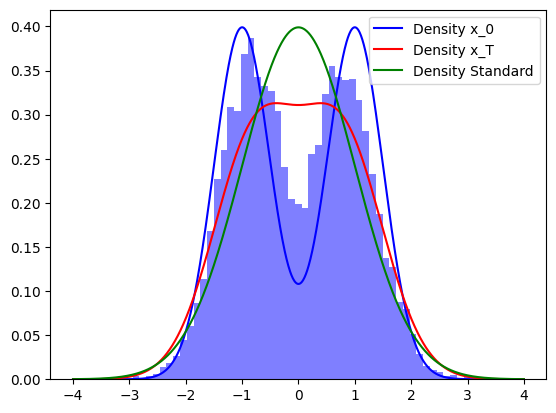

In [24]:
# Visualisation code
x_values = jnp.linspace(-4, 4, 1000)
density_x_0 = jnp.squeeze(gmm.noisy_density(jnp.expand_dims(x_values, axis=-1), 0))
density_x_T = jnp.squeeze(gmm.noisy_density(jnp.expand_dims(x_values, axis=-1), T-1))
density_standard = norm.pdf(x_values)
plt.hist(np.array(x_1), density=True, bins=50, color='blue', alpha=0.5)
#plt.hist(np.array(x_T), density=True, bins=50, color='red', alpha=0.5)
plt.plot(x_values, np.array(density_x_0), label='Density x_0', color='blue')
plt.plot(x_values, np.array(density_x_T), label='Density x_T', color='red')
plt.plot(x_values, np.array(density_standard), label='Density Standard', color='green')
plt.legend()
plt.show()

In [25]:
from jax.scipy.special import logsumexp

# Compute samples log-likelihood
log_likelihood = np.mean(gmm.log_density(x_1))
print(log_likelihood)
# Comptue efective sample size
adjusted_sample_size = num_samples/(1. + jnp.var(jnp.exp(log_w - logsumexp(log_w, axis=0, keepdims=True) + jnp.log(num_samples))))
print(adjusted_sample_size)


-1.4360012
233.96646


In [41]:
from models import MLP
# Generate RandomKey
key = jax.random.PRNGKey(0)
# Configuration
T = 50
# Parameters for the Gaussian Mixture Model (GMM)
prior = jnp.array([[0.5], [0.5]])  # Priors for the two components
means = jnp.array([[-1], [1]]) # Means for each component
stds = jnp.array([[0.5], [0.5]]) # Standard deviations for each component
num_samples = 10_000 # Number of samples to generate
# Definition of the score functions for forward and backward diffusions
# Score function based on noise
_sigma_squared = linear_schedule(T)
_gamma_squared = 1. - _sigma_squared
_gamma = jnp.sqrt(_gamma_squared)
_prod_gamma = jnp.cumprod(_gamma)
_prod_gamma_squared = jnp.cumprod(_gamma_squared)
# Initialise GMM

gmm = GMM(prior, means, stds, linear_schedule(T))

langevin_config = LangevinConfig(
    T=T, step_size=0.01
)

langevin_diffuser = LangevinDiffusion(langevin_config)

_sigma_squared = linear_schedule(T)
_gamma_squared = 1. - _sigma_squared
_gamma = jnp.sqrt(_gamma_squared)
_prod_gamma = jnp.cumprod(_gamma)
_prod_gamma_squared = jnp.cumprod(_gamma_squared)

# Initialise drift correction model
drift_correction = MLP(hidden_dim=128, out_dim=1, n_layers=3)
# Sample elements for initialisation
key, _ = jax.random.split(key)
x_T = jax.random.normal(key, shape=(T, 1))
t_T = jnp.expand_dims(jnp.linspace(start=0, stop=T, num=T)/T, axis=-1)
# Init with an element for all steps
params = drift_correction.init(key, jnp.concatenate([x_T, t_T], axis=-1))

# Zero last layers params
output_layer_name = list(params['params'].keys())[-1]

params["params"][output_layer_name]["kernel"] = jnp.zeros_like(params["params"][output_layer_name]["kernel"])
params["params"][output_layer_name]["bias"] = jnp.zeros_like(params["params"][output_layer_name]["bias"])

# Run backward diffusion
# x_T is N(0, 1)
key, _ = jax.random.split(key)
x_T = jax.random.normal(key, shape=(num_samples, 1))
# Split the random key
key, _ = jax.random.split(key)

# Do not include drift correction
x_1, log_w = langevin_diffuser.cmcd_train(
    params, 
    x_T, 
    drift_correction, 
    gmm.noisy_score_reversed,
    gmm.log_density,
    lambda x : norm.logpdf(x),
    (1. - _prod_gamma_squared),
    key,
)


In [33]:
print(params["params"]["Dense_0"].keys())
print(list(params['params'].keys()))

dict_keys(['kernel', 'bias'])
['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3']


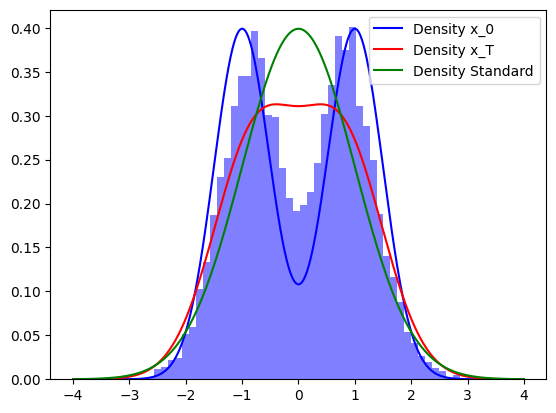

In [42]:
# Visualisation code
x_values = jnp.linspace(-4, 4, 1000)
density_x_0 = jnp.squeeze(gmm.noisy_density(jnp.expand_dims(x_values, axis=-1), 0))
density_x_T = jnp.squeeze(gmm.noisy_density(jnp.expand_dims(x_values, axis=-1), T-1))
density_standard = norm.pdf(x_values)
plt.hist(np.array(x_1), density=True, bins=50, color='blue', alpha=0.5)
#plt.hist(np.array(x_T), density=True, bins=50, color='red', alpha=0.5)
plt.plot(x_values, np.array(density_x_0), label='Density x_0', color='blue')
plt.plot(x_values, np.array(density_x_T), label='Density x_T', color='red')
plt.plot(x_values, np.array(density_standard), label='Density Standard', color='green')
plt.legend()
plt.show()

In [43]:
from jax.scipy.special import logsumexp

# Compute samples log-likelihood
log_likelihood = np.mean(gmm.log_density(x_1))
print(log_likelihood)
# Comptue efective sample size
adjusted_sample_size = num_samples/(1. + jnp.var(jnp.exp(log_w - logsumexp(log_w, axis=0, keepdims=True) + jnp.log(num_samples))))
print(adjusted_sample_size)


-1.4240788
17.599977
